# Stim only 
# train = multi-pixel, test = single pixel 
# compare lasso and non-lasso

In [1]:
import ssm
from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from real_spike.utils import *

from scipy.ndimage import gaussian_filter1d

import random
import h5py

import fastplotlib as fpl
from ipywidgets import IntSlider, VBox, Layout, Select, HBox

from PIL import Image
%matplotlib inline

Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅,Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,Vulkan,Mesa 25.0.4
✅ (default),NVIDIA GeForce RTX 4060 Laptop GPU,DiscreteGPU,Vulkan,565.77
❗ limited,"llvmpipe (LLVM 19.1.7, 256 bits)",CPU,Vulkan,Mesa 25.0.4 (LLVM 19.1.7)
❌,Mesa Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,OpenGL,4.6 (Core Profile) Mesa 25.0.4


Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


In [2]:
path = f"/home/clewis/repos/realSpike/data/rb67_20250929/"

# Get data

In [3]:
f = h5py.File("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb67/20250929/MAT_FILES/rb67_20250929_datastruct_pt2.mat", 'r')
data = f['data']
print(data.keys())

<KeysViewHDF5 ['aligned_laser_rec_time', 'laser_rec_time', 'pattern_id', 'pattern_library', 'totTime']>


In [4]:
data["pattern_library"]

<HDF5 dataset "pattern_library": shape (16, 6280), type "<f8">

In [5]:
data["pattern_id"]

<HDF5 dataset "pattern_id": shape (6464, 1), type "<f8">

In [6]:
data["aligned_laser_rec_time"]

<HDF5 dataset "aligned_laser_rec_time": shape (6464, 1), type "<f8">

# Plot a pattern

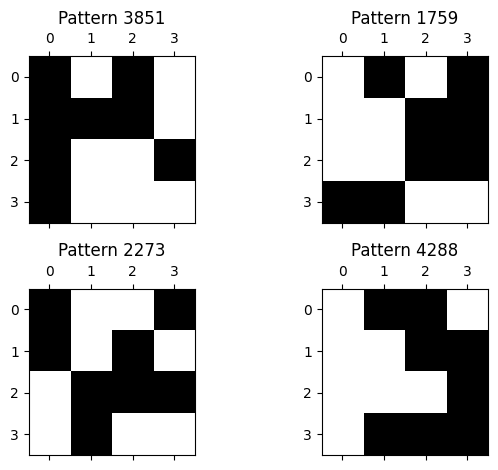

In [7]:
fig, axes = plt.subplots(2, 2) 

axes = axes.flatten()

ids = [random.randint(0, data["pattern_id"].shape[0]-1) for _ in range(4)]

for i in range(4):
    p_id = int(data["pattern_id"][ids[i], 0]) - 1
    axes[i].matshow(data["pattern_library"][:, p_id].reshape(4,4), cmap="binary")
    axes[i].set_title(f"Pattern {ids[i]}")

plt.tight_layout()

plt.show()


## Get which patterns are single pixel

In [8]:
num_trials = data["pattern_id"].shape[0]
num_trials

6464

In [14]:
single_pixels = list()

for i in range(num_trials):
    p_id = int(data["pattern_id"][i, 0])
    if data["pattern_library"][:, p_id-1].sum() == 1:
       # print(data["pattern_library"][:, p_id-1])
        single_pixels.append(1)
    else:
        single_pixels.append(0)

In [15]:
len(single_pixels)

6464

## Get the AP.bin file

In [16]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb67/20250929/rb67_20250929_g7/rb67_20250929_g7_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb67/20250929/rb67_20250929_g7/rb67_20250929_g7_t0.imec0.ap.meta")

In [17]:
meta_data = get_meta(meta_path)

In [18]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 227788964)

## Get conversion params

In [19]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

(vmax, imax, gain)

(0.6, 512.0, 500.0)

In [20]:
data["aligned_laser_rec_time"].shape

(6464, 1)

# Get the model data and save it out

In [22]:
def get_trials(idxs, bin_size, single_pixels):
    
    train_data = list()
    test_data = list()
    
    for j in tqdm(idxs):
        # get time points in ap space
        pre = 50 # 50 ms before
        stim = data["aligned_laser_rec_time"][j, 0] 
        start_time = int((stim - pre) / 1_000 * 30_000) # AP sample space
        
        stim_t = 5 # stim for 5 ms 
        post = 50 # take 50 ms after stim 
        end_time = int((stim + stim_t + post) / 1_000 * 30_000) # AP sample space
    
        trial = ap_data[:150, start_time:end_time+1]
    
        conv_data = 1e6 * trial / vmax / imax / gain
    
        filt_data = butter_filter(conv_data, 1_000, 30_000)
    
        m_start = int(start_time - (30 * 1000))
        trial_median = ap_data[:150, m_start:start_time]
    
        trial_median = 1e6 * trial_median / vmax / imax / gain
        trial_median = butter_filter(trial_median, 1_000, 30_000)
        
        median = np.median(trial_median, axis=1)
    
        spike_ixs, counts = get_spike_events(filt_data, median)
        
        a = np.zeros((filt_data.shape[0], filt_data.shape[1]))
    
        for i, sc in enumerate(spike_ixs):
            a[i, sc] = 1
    
        b = bin_size * 30 # 30ms per bin
        binned_spikes = bin_spikes(a, b)

        if single_pixels[j] == 1:
            test_data.append(np.asarray(binned_spikes.T, dtype=int))
        else:
            train_data.append(np.asarray(binned_spikes.T, dtype=int))
        
    return train_data, test_data

In [23]:
single_pixels[:5]

[1, 0, 0, 0, 0]

In [24]:
bin_size = 1

In [25]:
idxs = [i for i in range(5)]
idxs[:5]

[0, 1, 2, 3, 4]

In [26]:
train_data, test_data = get_trials(idxs, bin_size, single_pixels)

  0%|          | 0/5 [00:00<?, ?it/s]

add to test


In [27]:
len(train_data)

4

In [28]:
len(test_data)

1

# Save or load the train and test data

In [ ]:
# save as a pickle file 
import pickle

In [ ]:
filename = f"/home/clewis/repos/realSpike/data/rb67_20250929/{bin_size}ms_train_data.pkl"
with open(filename, "wb") as file:
    pickle.dump(train_data, file)

In [ ]:
with open(filename, "rb") as file:
    train_data = pickle.load(file)

In [ ]:
filename = f"/home/clewis/repos/realSpike/data/rb67_20250929/{bin_size}ms_test_data.pkl"
with open(filename, "wb") as file:
    pickle.dump(test_data, file)

In [ ]:
with open(filename, "rb") as file:
    test_data = pickle.load(file)

In [65]:
model_data[1]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], shape=(105, 150))

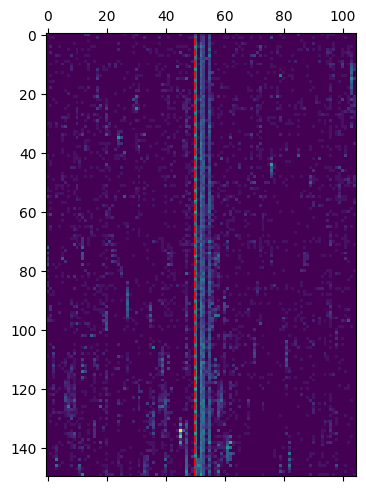

In [66]:
plt.matshow(model_data[1].T)
plt.axvline(50, linestyle="--", c="red")